In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from collections import Counter 
from wordcloud import WordCloud

# Data Analysis on Data Role Recruitment

The background is that we would like to understand the state of the data landscape in Malaysia. To answer these questions from a data perspective, we will take data from job recruitment sites such as Linkedin/JobStreet/Glassdoor. To be clear, we will define the following as data roles.

- Data Engineer
- Data Analyst
- Data Scientist
- ML Engineer

## How we measure

- Developer to data ratio/odds: For a baseline, we need to compare data roles to what is already more well known in tech, namely that of developers. Given there are more developers than data folks out there, this provides a benchmark in terms of how many data folks we should expect to see. This metric measures the rough demand of how much data roles are in demand. 

## Sampling for a general case

We begin by searching for the terms for both data and developer roles in the recruitment website engines. We then record the number of matches. We use the following terms and we require exact matching terms here. (quotation marks ""). We also measure the response for both Malaysia and Singapore, the reason being Singapore would be an indicator of a more developed data industry similar to US/Europe and what Malaysia could look like in the future.
- Developer: "software engineer", "developer", "programmer"
- Data: "data engineer", "data analyst", "data scientist"

The results are then recorded for simple analysis.


In [16]:
ag = pd.read_csv('./data/agg_role_count.csv')

In [18]:
ag['is_developer'] = ag.Keyword.isin(['Software Engineer','Programmer','Developer'])
ag['is_data'] = ag.Keyword.isin(['Data Engineer','Data Scientist','Data Analyst'])

### Simple analysis on aggregate
We note the following.
- Malaysia lags behind Singapore in terms of the developer to data ratio, so for Singapore, there is a higher demand for data roles that is not present in Malaysia. (6.13 vs 4.11)
- Given that we are hiring for a data role, Malaysia has a much higher proportion of data analyst/engineer roles demanded compared to Singapore.
- In Malaysia, the developer to data ratio for entry roles is lower than overall, suggesting that, the industry is still very young in general.

This leads us in the next direction which is to explore why there is a difference here. If we look at the size of the company, does this tell us more information about the demand? We know that bigger companies are more likely going to require data roles because they have the capacity and need for it. Is it that Singapore has bigger companies in general, or is it overall, the data industry is just more developed there?



In [22]:
(
ag[ag.is_developer].groupby(['Country'])['Role Count'].sum()/
ag[ag.is_data].groupby(['Country'])['Role Count'].sum()
)

Country
Malaysia     6.131498
Singapore    4.111361
Name: Role Count, dtype: float64

In [28]:
# % of data roles by country. Singpore is equal where Malaysia is more dominated by analysts.

(ag[ag.is_data].groupby(['Country','Keyword'])['Role Count'].sum()/
ag[ag.is_data].groupby(['Country'])['Role Count'].sum()
).unstack(level=1)

Keyword,Data Analyst,Data Engineer,Data Scientist
Country,,,
Malaysia,0.510703,0.309888,0.179409
Singapore,0.339708,0.329584,0.330709


In [24]:
## Entry level roles only

(
ag[(ag.is_developer)&(ag.Platform=='Linkedin (Entry)')].groupby(['Country'])['Role Count'].sum()/
ag[(ag.is_data)&(ag.Platform=='Linkedin (Entry)')].groupby(['Country'])['Role Count'].sum()
)

Country
Malaysia     4.723684
Singapore    3.244186
Name: Role Count, dtype: float64

## Sampling by company size

To split on the company size, we will need to sample the recruitment sites on a individual job by job level to distinguish the trends. The most practical way to sample data from these sites for such a tailored used case is to sample it individually by hand rather than scraping the database using an automated tool. Automated tools would be more useful if we're trying to see broader industry trends. 

Given the search engine could be biased to show adverts more frequently, we try to get around this bias by attempting to sample randomly across all of the search engine results. We also sample based on our observed distribution on the aggregate to try to get a representitive dataset of the population. What this turns out to be is that for all the search terms, since we have a total number of hits per site, we sample at random from these total hits.

After taking these, we check the company size and check if they have both a tech role and a data role (boolean). If yes, we continue. Some companies may have duplicate entries, and we'll only count them as one entry for the analysis to reduce bias. Some leads here may be outsourcing and we don't have information about the company, in which case, we will also remove from the data. Given the relatively small sample size, we will check the company posting the lead and check that they are indeed not from outsourcing. 

We first write the sampling function below. We choose a number of 300 samples per country as it was what was computationally feasible in the span of time.

In [175]:
# Recording the number of total hits.
# The first column in each list contains the number of entries per page. 
# This is used to help make the search easier.
# The rest of the columns correspond to the 6 search terms used for developer + data roles. 

hits_data = {
"linkedin":[25,456,1374,109,118,172,76],
"jobstreet":[32,185,745,55,66,82,35],
"glassdoor":[30,498,1965,269,102,197,57]
}

hits_sing = {
"linkedin":[25,928,905,32,200,159,199],
"jobstreet":[32,568,926,91,124,156,143],
"glassdoor":[30,1212,2114,255,242,247,222]
}

In [186]:
def sampler(hit_data,ratio):
    num_per_page = hit_data[0]    
    total_hits = hit_data[1:]

    # Sampling size refers to total samples we would like. It is represented as the % to sample
    # out of the total number recorded in the aggregate data. 
    
    sampling_size = [np.ceil(ratio*i) for i in total_hits]
    labels= ['se','dev','pro','de','da','ds']

    # Given we do not want duplicates, but only randomly generate
    # what we'll do is actually randomly sort a set list of numbers with cardinality of sampling_size entries. 
    
    rng = np.random.default_rng()
    sampler_array = rng.random(size=(6,max(total_hits)))

    ls = []
    
    for count, val in enumerate(labels):
        indices = sorted(range(0,total_hits[count]),key=lambda x: sampler_array[count][x])[:int(sampling_size[count])]
        indices.sort(reverse=True)
        page_index = [(np.floor(ind/num_per_page)+1, (ind % num_per_page)+1) for ind in indices]
        ls.append([{"term":val,"page":int(i[0]),"entry":int(i[1])} for i in page_index])

    return ls

In [74]:
# These ratios are calculated by hand based on what 300 as a % of the total hits we have.

linkedin = sampler(hits_data['linkedin'],0.0452)
jobstreet = sampler(hits_data['jobstreet'],0.0452)
glassdoor = sampler(hits_data['glassdoor'],0.0452)

linkedin_sg = sampler(hits_sing['linkedin'],0.03439)
jobstreet_sg = sampler(hits_sing['jobstreet'],0.03439)
glassdoor_sg = sampler(hits_sing['glassdoor'],0.03439)

In [182]:
smp = pd.concat([pd.DataFrame([j for i in linkedin for j in i]).assign(agency='linkedin'),
 pd.DataFrame([j for i in jobstreet for j in i]).assign(agency='jobstreet'),
 pd.DataFrame([j for i in glassdoor for j in i]).assign(agency='glassdoor'),
])

smp_sing = pd.concat([pd.DataFrame([j for i in linkedin_sg for j in i]).assign(agency='linkedin'),
 pd.DataFrame([j for i in jobstreet_sg for j in i]).assign(agency='jobstreet'),
 pd.DataFrame([j for i in glassdoor_sg for j in i]).assign(agency='glassdoor'),
])


In [77]:
smp.to_csv('./data/sampler_b.csv',index=False)
smp_sing.to_csv('./data/sampler_c.csv',index=False)

## Analysis and cleaning of the specific data

In [192]:
job = pd.read_csv('./data/job_mkt_data.csv')
job_s = pd.read_csv('./data/job_mkt_data_sng.csv')

As mentioned above, we need to dedupe because this view looks at company level and does not consider within the company, how many multiple roles can be present. We also remove outsourcing leads.

A problem emerges that we only know approximate company sizes within a range rather than true sizes. We will perform analysis based on approximate firm sizes (by taking a midpoint), and by looking at bins, which are specified by the recruiting job sites standards.

In [196]:
roles = job[(job.Duplicate==False)&(job['Is Outsource']==False)]
roles_s = job_s[(job_s.Duplicate==False)&(job_s['Is Outsource']==False)]

In [197]:
# Getting a numerical value for approximate firm size for the purposes.

def clean_size(x):
    if '+' in x:
        return int(x.replace('+',''))
    elif '-' in x:
        return (int(x.split('-')[0]) + int(x.split('-')[1]))/2
    else:
        return int(x)

roles['approx_firm_size'] = roles.Size.apply(clean_size)
roles_s['approx_firm_size'] = roles_s.Size.apply(clean_size)

roles['has_d_role'] = roles['Has Data (MY)'].astype(int) 
roles['has_s_role'] = roles['Has SE'].astype(int) 
roles_s['has_d_role'] = roles_s['Has Data (SG)'].astype(int) 
roles_s['has_s_role'] = roles_s['Has SE'].astype(int) 

roles['bins'] = pd.cut(roles.approx_firm_size,[0,50,200,1000,5000,20000])
roles_s['bins'] = pd.cut(roles_s.approx_firm_size,[0,50,200,1000,5000,20000])

Before we continue, let's explore the data a bit more. For the charts below, it seems that Singapore and Malaysia may have noisy trends due to the low data sizes. We will denoise it by performing a regression to represent what the true trend is that will allow a better comparison.

In [533]:
d_r = (roles.groupby(['bins']).has_d_role.sum()/roles.groupby(['bins']).has_d_role.count()
)
d_r_s = (roles_s.groupby(['bins']).has_d_role.sum()/roles_s.groupby(['bins']).has_d_role.count()
)

s_r = (roles.groupby(['bins']).has_s_role.sum()/roles.groupby(['bins']).has_s_role.count()
)
s_r_s = (roles_s.groupby(['bins']).has_s_role.sum()/roles_s.groupby(['bins']).has_s_role.count()
)

<Axes: title={'center': 'Sample Sizes of companies per country'}, xlabel='Company Size', ylabel='# of companies'>

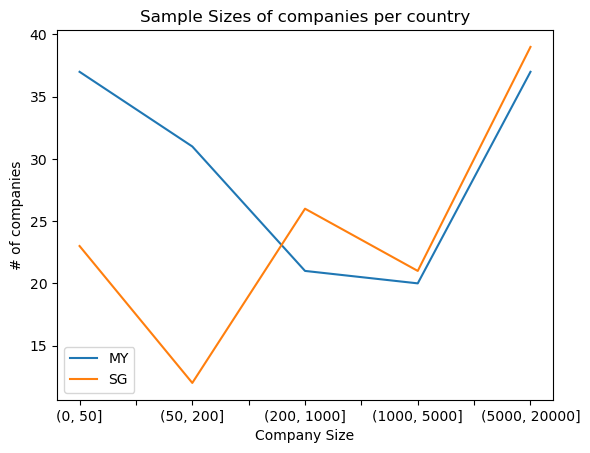

In [883]:
pd.concat([roles.groupby(['bins']).has_d_role.count().rename('MY'),
           roles_s.groupby(['bins']).has_d_role.count().rename('SG'),
          ],axis=1).plot(title='Sample Sizes of companies per country',
                        xlabel='Company Size',ylabel='# of companies')

<Axes: title={'center': 'Likelihood of Role in company'}, xlabel='Company Size', ylabel='Likelihood'>

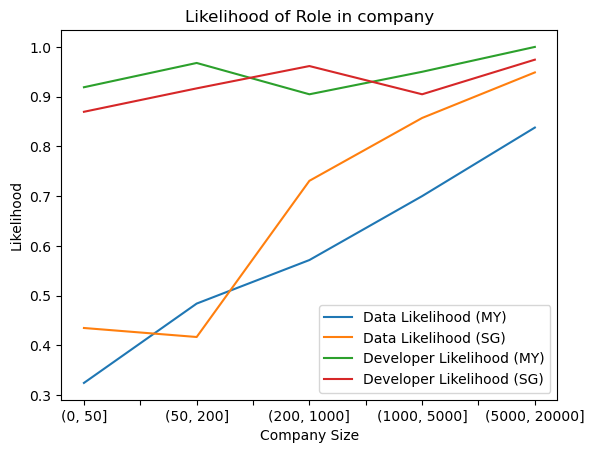

In [887]:
pd.concat([d_r.rename('Data Likelihood (MY)'),
           d_r_s.rename('Data Likelihood (SG)'),
           s_r.rename('Developer Likelihood (MY)'),
           s_r_s.rename('Developer Likelihood (SG)')]
          ,axis=1).plot(xlabel='Company Size',ylabel='Likelihood',
                       title='Likelihood of Role in company')

We will model using a cubic polynomial regression here to try to capture the kinks in the 50-1000 range that we see in several roles. We find that is has a better fit compared to a linear regression and as we are using this more of a predictor to remove noise, rather than causal indicator, it is slightly appropriate. 

In [ ]:
roles['a'] = roles.approx_firm_size**3
roles['b'] = roles.approx_firm_size**2
roles_s['a'] = roles_s.approx_firm_size**3
roles_s['b'] = roles_s.approx_firm_size**2

In [907]:
model = sm.Logit(roles_s['has_d_role'],sm.add_constant(roles_s[['a','b','approx_firm_size']]))
res_a = model.fit()

model = sm.Logit(roles_s['has_d_role'],sm.add_constant(roles_s[['approx_firm_size']]))
res_b = model.fit()

Optimization terminated successfully.
         Current function value: 0.453305
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.477020
         Iterations 7


In [908]:
# Cubic Approximation

print(res_a.summary())

                           Logit Regression Results                           
Dep. Variable:             has_d_role   No. Observations:                  121
Model:                          Logit   Df Residuals:                      117
Method:                           MLE   Df Model:                            3
Date:                Tue, 08 Oct 2024   Pseudo R-squ.:                  0.2153
Time:                        11:47:23   Log-Likelihood:                -54.850
converged:                       True   LL-Null:                       -69.898
Covariance Type:            nonrobust   LLR p-value:                 1.317e-06
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.2348      0.319     -0.735      0.462      -0.861       0.391
a                 3.014e-11   1.42e-11      2.126      0.034    2.35e-12    5.79e-11
b                -4.531e-07 

In [909]:
# Linear approximation. Has slightly worse performance here. 

print(res_b.summary())

                           Logit Regression Results                           
Dep. Variable:             has_d_role   No. Observations:                  121
Model:                          Logit   Df Residuals:                      119
Method:                           MLE   Df Model:                            1
Date:                Tue, 08 Oct 2024   Pseudo R-squ.:                  0.1742
Time:                        11:47:25   Log-Likelihood:                -57.719
converged:                       True   LL-Null:                       -69.898
Covariance Type:            nonrobust   LLR p-value:                 7.999e-07
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.1926      0.259      0.743      0.457      -0.315       0.700
approx_firm_size     0.0004      0.000      3.484      0.000       0.000       0.001


In [ ]:
model = sm.Logit(roles['has_d_role'],sm.add_constant(roles[['a','b','approx_firm_size']]))
res = model.fit()

roles['pred_d'] = model.predict(res.params,exog=sm.add_constant(roles[['a','b','approx_firm_size']]))

model = sm.Logit(roles['has_s_role'],sm.add_constant(roles[['a','b','approx_firm_size']]))
res = model.fit()

roles['pred_s'] = model.predict(res.params,exog=sm.add_constant(roles[['a','b','approx_firm_size']]))

In [545]:
model = sm.Logit(roles_s['has_d_role'],sm.add_constant(roles_s[['a','b','approx_firm_size']]))
res = model.fit()

roles_s['pred_d'] = model.predict(res.params,exog=sm.add_constant(roles_s[['a','b','approx_firm_size']]))

model = sm.Logit(roles_s['has_s_role'],sm.add_constant(roles_s[['a','b','approx_firm_size']]))
res = model.fit()

roles_s['pred_s'] = model.predict(res.params,exog=sm.add_constant(roles_s[['a','b','approx_firm_size']]))

Optimization terminated successfully.
         Current function value: 0.453305
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.237057
         Iterations 7


In [ ]:
roles['rtio'] = roles['pred_s']/roles['pred_d']
roles_s['rtio'] = roles_s['pred_s']/roles_s['pred_d']

Given our model, it is best to check that they still make sense relative to the original data. We see that our original data will have way higher odds compared to what we see in our aggregate data. Perhaps, this is due to us deduplicating roles as this does not take into account the full scope of how many roles there are within each company. 

In [910]:
(s_r/d_r)

bins
(0, 50]          2.833333
(50, 200]        2.000000
(200, 1000]      1.583333
(1000, 5000]     1.357143
(5000, 20000]    1.193548
dtype: float64

Given this, we will try to adjust the total by a certain factor multiplicatively so that the breakdown agrees with the aggregate. We will also bootstrap sample the roles to attempt to calculate a CI that could be expected as well of where the estimate per group could lie. We see that the odds can still vary widely, but it is consistent that Singapore is higher than Malaysia.

In [517]:
ls= []

# The average for MY is 6.246, so we need to adjust the group averages to be lower. 

for i in range(0,100):
    smp = roles.groupby('bins').sample(n=100,replace=True)
    adj_co = (0.2*((smp.groupby('bins').has_s_role.sum())/smp.groupby('bins').has_d_role.sum())).sum()
    r = 6.246/adj_co
    
    ls.append((((smp.groupby('bins').has_s_role.sum())/smp.groupby('bins').has_d_role.sum())*r).to_dict())

In [912]:
pd.concat([(s_r*3.35/d_r).rename('estimate'),
           pd.DataFrame(ls).quantile(0.025).rename('95% CI lower bound'),
           pd.DataFrame(ls).quantile(0.975).rename('95% CI upper bound')
          ],axis=1
         )

,estimate,95% CI lower bound,95% CI upper bound
"(0, 50]",9.491667,8.001231,12.395468
"(50, 200]",6.700000,5.632644,8.430486
"(200, 1000]",5.304167,4.591510,6.595953
"(1000, 5000]",4.546429,3.865290,5.407331
"(5000, 20000]",3.998387,3.633103,4.740055


In [540]:
ls_s= []

for i in range(0,100):
    smp = roles_s.groupby('bins').sample(n=100,replace=True)
    adj_co = (0.2*((smp.groupby('bins').has_s_role.sum())/smp.groupby('bins').has_d_role.sum())).sum()
    r = 4.155/adj_co
    
    ls_s.append((((smp.groupby('bins').has_s_role.sum())/smp.groupby('bins').has_d_role.sum())*r).to_dict())

In [913]:
pd.concat([(s_r_s*2.98/d_r_s).rename('estimate'),
           pd.DataFrame(ls_s).quantile(0.025).rename('95% CI lower bound'),
           pd.DataFrame(ls_s).quantile(0.975).rename('95% CI upper bound')
          ],axis=1
         )

,estimate,95% CI lower bound,95% CI upper bound
"(0, 50]",5.960000,4.400651,6.487557
"(50, 200]",6.556000,5.003382,7.176696
"(200, 1000]",3.921053,3.118910,4.141549
"(1000, 5000]",3.145556,2.587138,3.322075
"(5000, 20000]",3.060541,2.429013,3.156066


We now compare this to our model, which has a similar adjustment. The shape would now make it comparable, although it has caused some higher variances in the 50-1000 range as compensation of the noise. The low employee size of the MY model may suffer a bit of inaccuracy from this.

In [915]:
pd.concat([
    (s_r*3.35/d_r).rename('MY_raw'),
    (s_r_s*2.98/d_r_s).rename('SG_raw'),
    (roles.groupby(['bins']).rtio.mean().rename('MY_model')*3.45),
    (roles_s.groupby(['bins']).rtio.mean().rename('SG_model')*3.01)
    ],axis=1)

,MY_raw,SG_raw,MY_model,SG_model
bins,,,,
"(0, 50]",9.491667,5.960000,7.894975,6.041457
"(50, 200]",6.700000,6.556000,7.776616,5.537822
"(200, 1000]",5.304167,3.921053,6.325239,4.244645
"(1000, 5000]",4.546429,3.145556,4.578199,3.111350
"(5000, 20000]",3.998387,3.060541,4.129138,3.118886


To interpret this, we decide to plot the inverse as it'll give a sense of demand growing as the company grows larger as well. We clearly see that SG is ahead of MY. Furthermore, as expected, bigger companies would have larger demand for data roles compared to smaller companies. Can we decompose this demand into one that is intrisic to what companies are wanting (ready) vs those that are caused by lack of supply? We try to simulate this by matching the MY odds with the SG odds for the smallest size company, and scaling that amount across MY to try to represent what would happen if MY demand completely matched the SG demand, given supply changes for small companies are less likely to be sensitive. 

What we observe is that there is gap still for SG, which could indicate extra supply side issues that have yet to be fulfilled.

<Axes: xlabel='Company Size', ylabel='Odds of Data role (1x dev role)'>

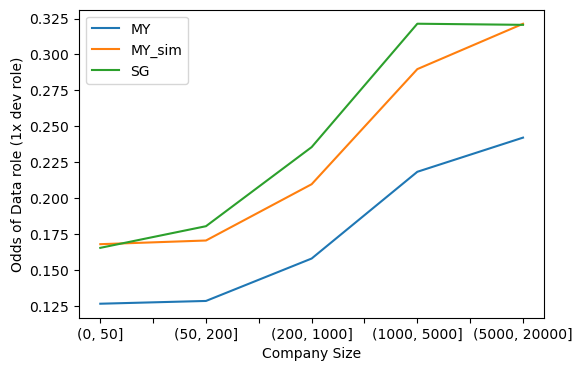

In [832]:
(1/pd.concat([(roles.groupby(['bins']).rtio.mean()*3.45).rename('MY'),
              (roles.groupby(['bins']).rtio.mean()*2.6).rename('MY_sim'),
           (roles_s.groupby(['bins']).rtio.mean()*3.01).rename('SG')]
          ,axis=1
         )).plot(xlabel='Company Size',ylabel='Odds of Data role (1x dev role)',
                figsize=(6,4)
                )

Overall, one can summarize the findings as following

- The above diagram indicates that there is still a supply shortage in SG, and therefore one would exist in MY. In particular, the gap is mostly in the mid-sized companies where they are unable to get too much traction, maybe because of their lack of notice.
- As expected, smaller company sizes are less likely to hire data roles, most likely because they don't need it. One may want to focus on bigger size companies instead. 

## Analyzing job scope from textual data

Given that we've understood some trends on the market, let's also look at the job scope to see what skills are required. Similar to the above, we can sample data from engineering/analyst/scientist roles for job recruitment sites to get a job description and skills and we can extract relevant information and importance. 

In [4]:
job_scope = pd.read_csv('./data/job_text.csv')

job_scope_sg = pd.read_csv('./data/sg_roles.csv')

In [5]:
job_scope = job_scope.fillna('')
job_scope['Responsibility'] = job_scope['Responsibility'].str.lower()
job_scope['Qualifications'] = job_scope['Qualifications'].str.lower()
job_scope['text'] = job_scope['Responsibility'] + ' ' + job_scope['Qualifications']

job_scope_sg = job_scope_sg.fillna('')
job_scope_sg['Responsibility'] = job_scope_sg['Responsibility'].str.lower()
job_scope_sg['Qualifications'] = job_scope_sg['Qualifications'].str.lower()
job_scope_sg['text'] = job_scope_sg['Responsibility'] + ' ' + job_scope_sg['Qualifications']

In terms of the important terms below, these are parsed quickly from the descriptions of the data and specific key terms were taken if they are relevant based on domain understanding for DE/DS/DA roles. (there's only 74 data points, so easy to look through). The specific codes list the hard skills, where the others are more of job scope required that we should look up. Text matching will be more on regex given that sample size is small, and we have an idea of what question to answer. 

In [6]:
# List of key terms or tools.
skill_terms = [
'python',
'sql',
'postgres',
'mysql',
'nosql',
'excel',
'power',
'tableau',
'etl','elt','dbt',
'git','hadoop','presto',
'cloud','aws','azure','snowflake','spark',
    'olap','database','warehouse',
'avro','parquet',
    'sas','bricks','a/b',
    'tensorflow','torch',
    'google analytics','sap','kafka',
    'java','informatica','iics','salesforce',
    'sense',
    'agile','jira','pipeline','experiment','linux',
'machine learning',
'ml',
'data model',
'dashboard',
'algorithm','c+'
]

specific_codes = [
'python',
'sql',
'postgres',
'mysql',
'excel',
'powerbi',
'tableau',
'dbt',
'hadoop','presto',
'aws','azure','snowflake','spark',
    'sas','bricks',
    'tensorflow','torch',
    'google analytics','sap','kafka',
    'java','informatica','iics','salesforce',
    'sisense','c+'
]

# Responsibilities
responsibilities_map = {
'nosql':['ETL'],
'excel':['Dashboard'],
'power':['Dashboard'],
'tableau':['Dashboard'],
'etl':['ETL'],'elt':['ETL'],'dbt':['ETL'],
'git':['Agile'],'hadoop':['ETL','Hadoop'],'presto':['ETL','Hadoop'],
'cloud':['Cloud'],'aws':['Cloud'],'azure':['Cloud'],'snowflake':['Warehouse','ETL'],'spark':['ETL','Hadoop'],
    'olap':['Data Model'],'database':['ETL','Data Model'],'warehouse':['Warehouse'],
    'sas':['Model'],'bricks':['Warehouse','Cloud'],'a/b':['Experiment'],
    'tensorflow':['Model'],'torch':['Model'],
    'google analytics':['Dashboard'],'kafka':['ETL','Cloud'],
    'sense':['Dashboard'],
    'agile':['Agile'],'jira':['Agile'],'pipeline':['ETL'],'experiment':['Experiment'],
'machine learning':['Model'],
'ml':['Model'],
'data model':['Data Model'],
'dashboard':['Dashboard'],
'algorithm':['Model'],
}

In [9]:
def return_text(x):
    return [i for i in skill_terms if i in x]

def return_role(x):
    t = [i for i in skill_terms if i in x]
    r_map = [responsibilities_map.get(i) for i in t if responsibilities_map.get(i) is not None ]
    r_map = set([j for i in r_map for j in i])
    return r_map

def recat(x):
    if 'ngine' in x or 'dev' in x:
        return 'engineer'
    elif 'naly' in x:
        return 'analyst'
    elif 'cien' in x:
        return 'scientist'
    else: 
        return 'analyst'

def replace_text(txt):
    if txt=='sense':
        return 'sisense'
    elif txt=='power':
        return 'powerbi'
    else:
        return txt

def iter_over_list(dataframe,column):
    hint = dataframe.shape[0]
    term_list = [replace_text(j) for i in dataframe[column].to_list() for j in i]
    cnt = Counter(term_list)
    
    if column=='prs':
        cnt = {key: np.round(cnt[key]/hint,2) for key in cnt if key in specific_codes}
    else:
        cnt = {key: np.round(cnt[key]/hint,2) for key in cnt}
    return cnt

In [10]:
job_scope['prs'] = job_scope['text'].apply(return_text)
job_scope['jd'] = job_scope['text'].apply(return_role)

job_scope_sg['prs'] = job_scope_sg['text'].apply(return_text)
job_scope_sg['jd'] = job_scope_sg['text'].apply(return_role)

In [11]:
job_scope['abbr_role'] = job_scope['Role'].apply(recat)
job_scope_sg['abbr_role'] = job_scope_sg['Role'].apply(recat)

In [12]:
dist_dict = {}
j_dict = {}
dist_dict_sg = {}
j_dict_sg = {}

for name, group in job_scope.groupby('abbr_role'):
    dist_dict.update({name:iter_over_list(group,'prs')})

dist_dict.update({'general':iter_over_list(job_scope,'prs')})

for name, group in job_scope.groupby('abbr_role'):
    j_dict.update({name:iter_over_list(group,'jd')})

j_dict.update({'general':iter_over_list(job_scope,'jd')})



for name, group in job_scope_sg.groupby('abbr_role'):
    dist_dict_sg.update({name:iter_over_list(group,'prs')})

dist_dict_sg.update({'general':iter_over_list(job_scope,'prs')})

for name, group in job_scope_sg.groupby('abbr_role'):
    j_dict_sg.update({name:iter_over_list(group,'jd')})

j_dict_sg.update({'general':iter_over_list(job_scope,'jd')})

### Hard Skills

For hard skills, we find that it agrees with our general intuition that
1. Python and SQL are high in demand universally among all roles.
2. For analyst/scientist roles, Excel, SQL and other dashboarding skills are in demand.
3. For data scientists, 
4. For engineers, knowledge of Cloud stacks are important. Surprisingly, data processing frameworks such as Hadoop/Kafka are also important enough that one framework should be taught. For scientist, some cloud knowledge is also appreciated.


In [14]:
pd.DataFrame(dist_dict).fillna(0)

,analyst,engineer,scientist,general
excel,0.69,0.24,0.36,0.49
python,0.46,0.68,1.00,0.61
sql,0.56,0.68,0.82,0.64
tableau,0.36,0.16,0.36,0.29
sas,0.15,0.04,0.09,0.11
powerbi,0.38,0.16,0.27,0.29
java,0.05,0.28,0.09,0.13
sisense,0.08,0.12,0.09,0.09
c+,0.03,0.08,0.00,0.04
dbt,0.05,0.00,0.00,0.03


In [13]:
pd.DataFrame(dist_dict_sg).fillna(0)

,analyst,engineer,scientist,general
sql,0.86,0.69,0.33,0.64
spark,0.14,0.56,0.17,0.21
java,0.07,0.31,0.08,0.13
python,0.57,0.62,0.75,0.61
excel,0.43,0.38,0.17,0.49
powerbi,0.57,0.19,0.08,0.29
tableau,0.64,0.12,0.08,0.29
sisense,0.14,0.06,0.00,0.09
sap,0.14,0.00,0.00,0.04
postgres,0.14,0.12,0.00,0.07


### Job Scope

In terms of job scope, what we find is that the analyst is more in line with the scientist than the engineer in terms of needing dashboarding skills as a main priority. However, we do find that analyst is somewhat of a hybrid of both roles given they have high emphasis on ETL and data modelling similar to data scientist, who are required to be more specialized in experiments and model building. 


In [701]:
pd.DataFrame(j_dict)

,analyst,engineer,scientist,general
Dashboard,0.87,0.48,0.73,0.72
Agile,0.28,0.16,0.27,0.24
Model,0.26,0.44,0.82,0.40
Experiment,0.13,0.08,0.45,0.16
Data Model,0.46,0.64,0.45,0.52
ETL,0.51,0.80,0.45,0.60
Cloud,0.13,0.76,0.55,0.40
Warehouse,0.15,0.52,0.18,0.28
Hadoop,0.13,0.48,0.09,0.24


In [15]:
pd.DataFrame(j_dict_sg)

,analyst,engineer,scientist,general
Dashboard,0.79,0.56,0.33,0.72
Hadoop,0.14,0.56,0.17,0.24
ETL,0.57,0.94,0.42,0.60
Warehouse,0.29,0.38,NaN,0.28
Data Model,0.50,0.44,0.08,0.52
Model,0.36,0.31,0.92,0.40
Experiment,0.14,NaN,0.08,0.16
Cloud,0.21,0.56,0.17,0.40
Agile,NaN,0.19,0.25,0.24


## Appendix

Below are some charts used for slides that may be useful.

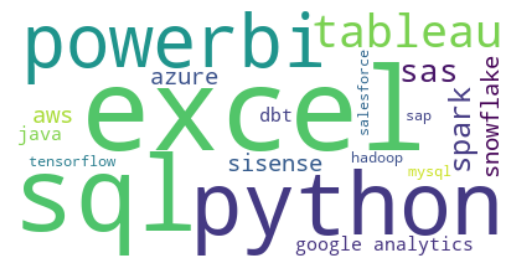

In [853]:
wc = WordCloud(background_color="white", max_words=1000)
# generate word cloud
wc.generate_from_frequencies(dist_dict['analyst'])

# show
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()


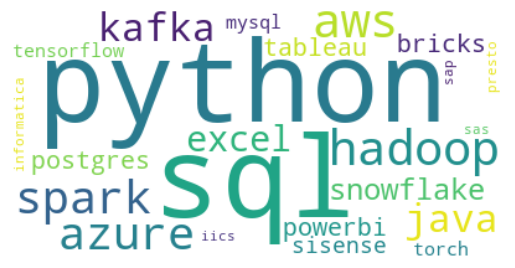

In [858]:
wc = WordCloud(background_color="white", max_words=1000)
# generate word cloud
wc.generate_from_frequencies(dist_dict['engineer'])

# show
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()


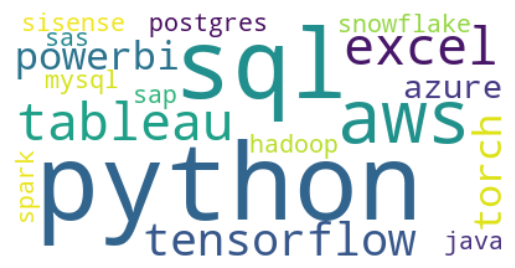

In [859]:
wc = WordCloud(background_color="white", max_words=1000)
# generate word cloud
wc.generate_from_frequencies(dist_dict['scientist'])

# show
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()


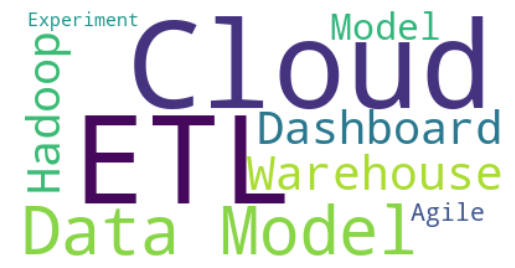

In [855]:
wc = WordCloud(background_color="white", max_words=1000)
# generate word cloud
wc.generate_from_frequencies(j_dict['engineer'])

# show
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()


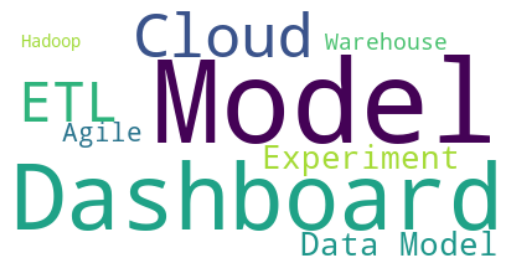

In [856]:
wc = WordCloud(background_color="white", max_words=1000)
# generate word cloud
wc.generate_from_frequencies(j_dict['scientist'])

# show
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()


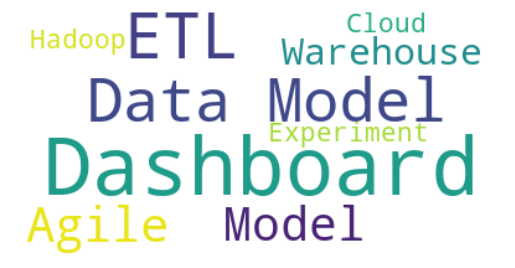

In [857]:
wc = WordCloud(background_color="white", max_words=1000)
# generate word cloud
wc.generate_from_frequencies(j_dict['analyst'])

# show
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()


(-0.4740331491712707, 0.7900552486187845)

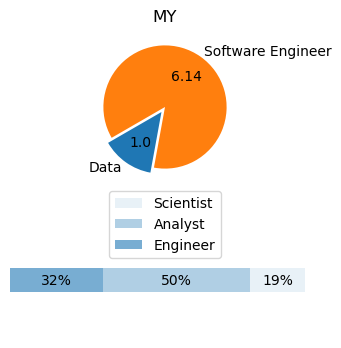

In [788]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(4, 4))
fig.subplots_adjust(hspace=0)

def pct_label(pct):
    absolute = np.round(np.round(pct)/14,2)
    return absolute


# pie chart parameters
overall_ratios = [905,5656,]
labels = ['Data','Software Engineer',]
explode = [0.1, 0]
# rotate so that first wedge is split by the x-axis
wedges, *_ = ax1.pie(overall_ratios, startangle=-150,autopct=pct_label,
                     labels=labels, explode=explode)

ax1.set_title('MY')

# bar chart parameters
age_ratios = [286/905,451/905,168/905]
age_labels = ['Engineer', 'Analyst', 'Scientist']
bottom = 1
width = .2

# Adding from the top matches the legend.
for j, (height, label) in enumerate(reversed([*zip(age_ratios, age_labels)])):
    bottom -= height
    bc = ax2.barh(0, height, width, left=bottom, color='C0', label=label,
                 alpha=0.1 + 0.25 * j)
    ax2.bar_label(bc, labels=[f"{height:.0%}"], label_type='center')

ax2.legend(loc='upper center')
ax2.axis('off')
ax2.set_ylim(- 1.5 * height, 2.5 * height)



(-0.50177304964539, 0.8362884160756501)

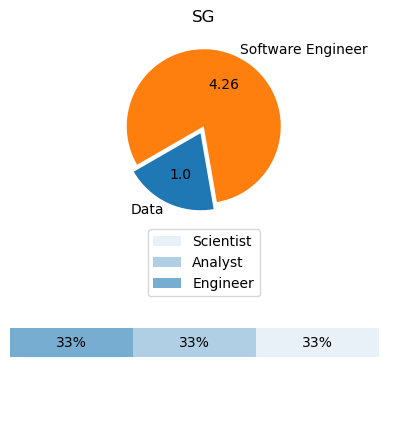

In [29]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 5))
fig.subplots_adjust(hspace=0)

def pct_label(pct):
    absolute = np.round(np.round(pct)/19,2)
    return absolute


# pie chart parameters
overall_ratios = [1692,7031,]
labels = ['Data','Software Engineer',]
explode = [0.1, 0]
# rotate so that first wedge is split by the x-axis
wedges, *_ = ax1.pie(overall_ratios, startangle=-150,autopct=pct_label,
                     labels=labels, explode=explode)

ax1.set_title('SG')

# bar chart parameters
age_ratios = [566/1692,562/1692,564/1692]
age_labels = ['Engineer', 'Analyst', 'Scientist']
bottom = 1
width = .2

# Adding from the top matches the legend.
for j, (height, label) in enumerate(reversed([*zip(age_ratios, age_labels)])):
    bottom -= height
    bc = ax2.barh(0, height, width, left=bottom, color='C0', label=label,
                 alpha=0.1 + 0.25 * j)
    ax2.bar_label(bc, labels=[f"{height:.0%}"], label_type='center')

ax2.legend(loc='upper center')
ax2.axis('off')
ax2.set_ylim(- 1.5 * height, 2.5 * height)

